In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# FGF In vitro Data - Mesp-b::mKate Analysis
<a id='top'></a>

## Table of contents for this notebook

- [Data Import](#import): Upload the in vitro data to compare PSM4 vs PSM4 + FGF cells.

- [Plot all PSM4 cells](#psm4_plot): Plot all the PSM4 cells. These cells express Her1::YFP (Looping) and Mesp-b::mKate (Heidi).

- [Plot all PSM4 cells](#fgf_plot): Plot all the PSM4 cells treated with fgf8. These cells express Her1::YFP (Looping) and Mesp-b::mKate (Heidi).

- [Load and plot Peaks](#peaks): Here we load and show all the peaks detected in the notebook *FGF_ManualPeakSelector.ipynb*


### Upload the xlsx files

<a id='import'></a>
If you want to go to the top of the notebook click here: [Top](#top)

In [2]:
psm4 = [[2, 4, 7, 16, 24, 29, 31, 32, 33, 37, 48, 38, 40, 41, 45, 48, 49], 
       [38, 40, 41, 45, 48, 49],
       [50, 53, 55, 57, 58, 61, 64, 65, 67, 68, 71, 73],
       [2, 6, 7, 10, 24, 25, 27, 31, 33, 35, 36, 40, 43, 46, 48]]

psm4_fgf = [[53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 69, 70, 76, 79, 81, 82, 84, 98, 102, 104, 108], 
            [52, 54, 55, 59, 61],
            [87, 90, 91, 93, 95, 98, 101, 104, 105, 107, 108],
            [54, 55, 56, 60, 61, 62, 63, 67, 68, 69, 70, 71, 76, 79, 94, 97, 105]]

In [3]:
# Seeding times (Minutes post disociation)

seeds = [80, 60, 70, 60]

In [4]:
experiments = [436, 443, 444, 433]

data_looping = [] # looping intensities
data_heidi = [] # heidi intensities
tod = [] # time of death
positions = []

seed_times = [] # Times for seeding in plate

label = [] # PSM4, FGF or none

for i, exp in enumerate(experiments):
    # Read the excel files - each sheet contains the looping or heidi intensities
    looping = pd.read_excel(f'../Data/FGF/wsc{exp}_mean_intensities_2022.xlsx', 
                            sheet_name = 'looping', header=[0])

    heidi = pd.read_excel(f'../Data/FGF/wsc{exp}_mean_intensities_2022.xlsx', 
                            sheet_name = 'heidi', header=[0])
    
    # Each experiment contains different cell positions
    positions.append(looping.keys().to_numpy()[1:])
    
    for pos in positions[i]:

        data_looping.append(looping[pos][1:].to_numpy())
        data_heidi.append(heidi[pos][1:].to_numpy())
        tod.append(looping[pos][0])
        seed_times.append(seeds[i])
        
        if any(pos == np.array(psm4[i])):
            label.append('psm4')
        elif any(pos == np.array(psm4_fgf[i])):
            label.append('fgf')
        else:
            label.append('other')

n_cells = len(data_heidi)
looping.head() 

,position,2,6,7,10,24,25,27,31,33,...,67,68,69,70,71,76,79,94,97,105
0,TOD,67.000000,96.000000,78.000000,34.000000,62.000000,49.000000,48.000000,57.000000,56.000000,...,89.000000,87.000000,102.000000,121.000000,81.000000,49.000000,85.000000,60.000000,121.000000,121.000000
1,NaN,1124.608209,1113.306604,1157.834696,1113.533578,1144.284841,1134.995511,1109.366857,1151.278375,1136.839888,...,1105.369312,1223.439614,1132.674112,1112.731651,1156.412776,1159.939159,1126.243306,1123.891282,1133.910323,1163.630667
2,NaN,1184.880208,1170.239281,1186.582198,1152.308733,1171.918536,1248.068510,1136.544332,1200.523515,1149.974970,...,1102.378378,1258.888199,1145.122056,1106.761749,1202.491613,1203.380208,1137.211513,1201.383516,1127.926856,1187.427313
3,NaN,1176.413366,1200.920520,1241.033210,1358.415916,1167.230216,1466.799292,1171.849802,1239.163484,1167.107649,...,1129.124675,1240.583208,1158.689620,1111.563492,1199.661710,1163.808126,1129.246725,1211.403750,1124.945759,1170.970458
4,NaN,1172.209476,1166.420989,1268.540936,1451.276265,1172.391711,1603.680572,1141.747909,1272.262937,1139.220452,...,1138.324655,1207.305671,1159.585487,1111.191721,1163.326829,1193.938776,1141.762673,1210.366180,1138.900277,1240.509021


## Load peaks, intensities, indices
<a id='peaks'></a>

This data was obtained from the notebook FGF_ManualPeakSelector.


If you want to go to the top of the notebook click here: [Top](#top)

In [5]:
peak_time_max = np.load('../Data/FGF/peak_time_max.npy', allow_pickle=True)
max_val = np.load('../Data/FGF/max_val.npy', allow_pickle=True)
peak_time_min = np.load('../Data/FGF/peak_time_min.npy', allow_pickle=True)
min_val = np.load('../Data/FGF/min_val.npy', allow_pickle=True)
intensities = np.load('../Data/FGF/intensities.npy', allow_pickle=True)
labels = np.load('../Data/FGF/labels.npy', allow_pickle=True)
inds = np.load('../Data/FGF/inds.npy', allow_pickle=True)

In [6]:
# Time step of imaging - in minutes
tr = 10

### Mesp intensities only on peak detected cells + Last Her1 Peak

In [7]:
intensities_mesp = []
last_peak_her1 = []
n_cells = len(inds)
label = []
seed_times_use = []

for i,val in enumerate(inds):
    
    # If there is any peak at all
    if np.size(peak_time_max[i])>0:
        # And drop any NaN values
        intensities_mesp.append(data_heidi[val][~np.isnan(data_heidi[val])])
        last_peak_her1.append(peak_time_max[i][-1])
        label.append(labels[i])
        seed_times_use.append(seed_times[val])

## Mesp Traces

<a id='traces'></a>

If you want to go to the top of the notebook click here: [Top](#top)

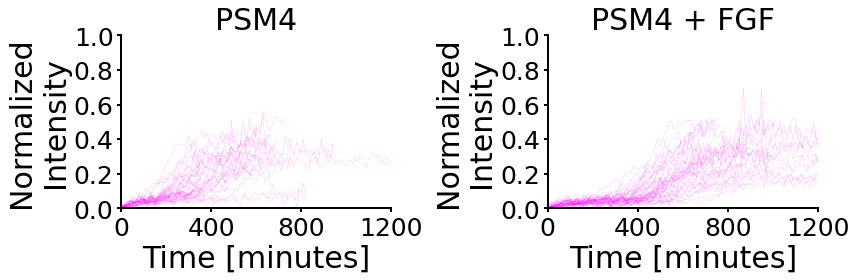

In [8]:
fig = plt.figure(figsize=[12,4])

plt.subplot(121)

inds = np.where(np.array(label)=='psm4')[0]

for i in inds:
    plt.plot(np.arange(len(intensities_mesp[i]))*tr, 
             (intensities_mesp[i]-np.min(intensities_mesp[i]))/np.max(intensities_mesp[i]),
            color = 'magenta', linewidth=0.2, alpha=0.5)
    
plt.xlim([0,1200])
plt.ylim([0,1])
plt.title('PSM4', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

inds = np.where(np.array(label)=='fgf')[0]

for i in inds:
    plt.plot(np.arange(len(intensities_mesp[i]))*tr, 
             (intensities_mesp[i]-np.min(intensities_mesp[i]))/np.max(intensities_mesp[i]),
            color = 'magenta', linewidth=0.2, alpha=0.5)
    
plt.xlim([0,1200])
plt.ylim([0,1])
plt.title('PSM4 + FGF', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/MespTracesAll-FGFandPSM4.pdf', format='pdf', bbox_inches='tight')

### Same plot as before with Seed Times

<a id='traces_seed'></a>

Show the Mesp traces but starting at the corresponding seed times. 


If you want to go to the top of the notebook click here: [Top](#top)

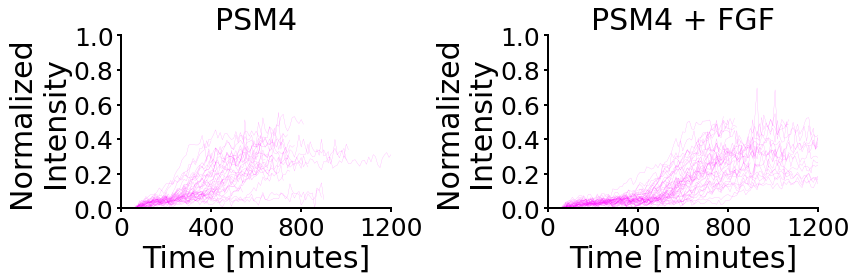

In [9]:
fig = plt.figure(figsize=[12,4])

plt.subplot(121)

inds = np.where(np.array(label)=='psm4')[0]

for i in inds:
    plt.plot(seed_times_use[i]+np.arange(len(intensities_mesp[i]))*tr, 
             (intensities_mesp[i]-np.min(intensities_mesp[i]))/np.max(intensities_mesp[i]),
            color = 'magenta', linewidth=0.2, alpha=0.5)
    
plt.xlim([0,1200])
plt.ylim([0,1])
plt.title('PSM4', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

inds = np.where(np.array(label)=='fgf')[0]

for i in inds:
    plt.plot(seed_times_use[i]+np.arange(len(intensities_mesp[i]))*tr, 
             (intensities_mesp[i]-np.min(intensities_mesp[i]))/np.max(intensities_mesp[i]),
            color = 'magenta', linewidth=0.2, alpha=0.5)
    
plt.xlim([0,1200])
plt.ylim([0,1])
plt.title('PSM4 + FGF', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/MespTracesAll-FGFandPSM4-seeds.pdf', format='pdf', bbox_inches='tight')

### When is last peak of Her1 happening?

<a id='peaks'></a>
If you want to go to the top of the notebook click here: [Top](#top)

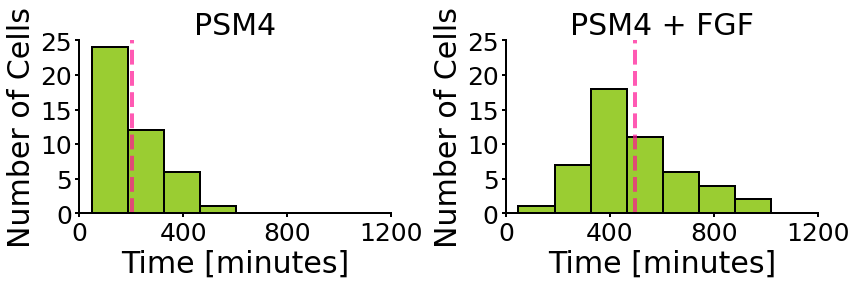

In [11]:
inds = np.where(np.array(label)=='psm4')[0]
last_her1_peak_psm4 = np.array(last_peak_her1)[inds]

inds = np.where(np.array(label)=='fgf')[0]
last_her1_peak_fgf = np.array(last_peak_her1)[inds]

# Obtain the same bin size for the two plots using the FD method
bins=np.histogram(np.hstack((last_her1_peak_psm4, last_her1_peak_fgf)), bins='fd')[1] #get the bin edges

fig = plt.figure(figsize=[12,4])

plt.subplot(121)

plt.hist(last_her1_peak_psm4, edgecolor='k', linewidth=2, color='yellowgreen', bins=bins)

plt.axvline(np.mean(last_her1_peak_psm4), linewidth=4, color='deeppink', alpha=0.7, 
           linestyle='dashed')

plt.xlim([0,1200])
plt.ylim([0, 25])
plt.title('PSM4', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(np.arange(0,30,5), fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Number of Cells', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

plt.hist(last_her1_peak_fgf, edgecolor='k', linewidth=2, color='yellowgreen', bins=bins)
plt.axvline(np.mean(last_her1_peak_fgf), linewidth=4, color='deeppink', alpha=0.7, 
           linestyle='dashed')

plt.xlim([0,1200])
plt.ylim([0,25])
plt.title('PSM4 + FGF', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(np.arange(0,30,5), fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Number of Cells', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/LasHer1PeakAll-FGFandPSM4.pdf', format='pdf', bbox_inches='tight')

In [12]:
print('PSM4 mean: ', np.mean(last_her1_peak_psm4))
print('PSM4 + FGF mean: ', np.mean(last_her1_peak_fgf))

PSM4 mean:  201.30067516879217
PSM4 + FGF mean:  497.100724160632


In [13]:
df_lp_psm4 = pd.DataFrame({'Last Her1 Peak (min)': last_her1_peak_psm4})
df_lp_fgf = pd.DataFrame({'Last Her1 Peak (min)': last_her1_peak_fgf})

In [14]:
df_lp_psm4.head()

,Last Her1 Peak (min)
0,111.000000
1,142.225806
2,111.780645
3,481.025806
4,139.103226


In [15]:
df_lp_fgf.head()

,Last Her1 Peak (min)
0,620.761290
1,567.677419
2,288.987097
3,370.174194
4,709.754839


In [16]:
df_lp_psm4.to_csv('../Data/FGF/FGF_Data_Simulation/PSM4_Her1_LastPeak.csv')
df_lp_fgf.to_csv('../Data/FGF/FGF_Data_Simulation/FGF_Her1_LastPeak.csv')

### Same plot as before with Seed Times

<a id='peaks_seed'></a>

Show the last Her1 Peak but starting at the corresponding seed times. 

If you want to go to the top of the notebook click here: [Top](#top)

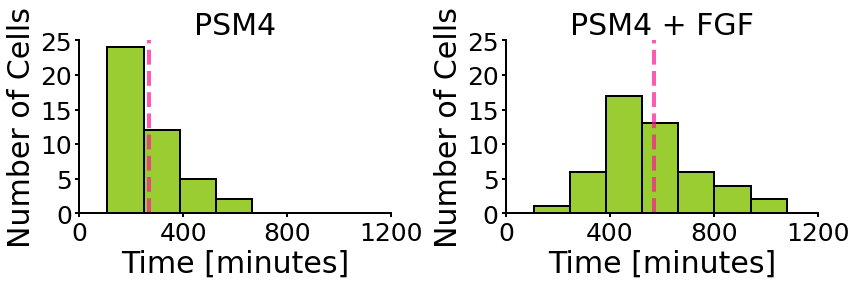

In [18]:
inds = np.where(np.array(label)=='psm4')[0]
last_her1_peak_psm4 = np.array(last_peak_her1)[inds]+np.array(seed_times_use)[inds]

inds = np.where(np.array(label)=='fgf')[0]
last_her1_peak_fgf = np.array(last_peak_her1)[inds]+np.array(seed_times_use)[inds]

# Obtain the same bin size for the two plots using the FD method
bins=np.histogram(np.hstack((last_her1_peak_psm4, last_her1_peak_fgf)), bins='fd')[1] #get the bin edges

fig = plt.figure(figsize=[12,4])

plt.subplot(121)

plt.hist(last_her1_peak_psm4, edgecolor='k', linewidth=2, color='yellowgreen', bins=bins)
plt.axvline(np.mean(last_her1_peak_psm4), linewidth=4, color='deeppink', alpha=0.7, 
           linestyle='dashed')

plt.xlim([0,1200])
plt.ylim([0, 25])
plt.title('PSM4', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(np.arange(0,30,5), fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Number of Cells', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

plt.hist(last_her1_peak_fgf, edgecolor='k', linewidth=2, color='yellowgreen', bins=bins)
plt.axvline(np.mean(last_her1_peak_fgf), linewidth=4, color='deeppink', alpha=0.7, 
           linestyle='dashed')

plt.xlim([0,1200])
plt.ylim([0,25])
plt.title('PSM4 + FGF', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(np.arange(0,30,5), fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Number of Cells', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/LasHer1PeakAll-FGFandPSM4-seeds.pdf', format='pdf', bbox_inches='tight')

In [19]:
print('PSM4 mean: ', np.mean(last_her1_peak_psm4))
print('PSM4 + FGF mean: ', np.mean(last_her1_peak_fgf))

PSM4 mean:  269.20765191297824
PSM4 + FGF mean:  567.5088874259382


## Align according to last peak

<a id='align'></a>

In order to better analyze Mesp data, we will first align the data according to Her 1 las peak (which will be our reference time to compare in vivo and in vitro data). However, we will use the data from the beginning of the movie, all the way until 2 hours after the last peak. 

If you want to go to the top of the notebook click here: [Top](#top)

### Last-peak alignment 

#### Mesp traces with the windows marked for fold change analysis

In black dashed lines, you have the lines that define the regions used to make the fold change analysis performed below. 

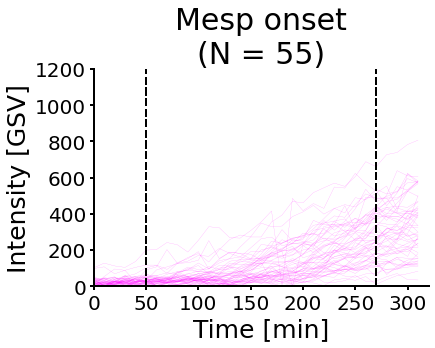

In [12]:
# Plot all Mesp tracks for each experiment separately

# Define the dimensions of the subplot

# Initialize the figure size
fig = plt.figure(figsize=[6,4])
   
window = 5

n_cells = len(intensities_mesp)
# start at time = 0, stop at time = last peak time + 2 hours
cut_off_val1 = 160 # in minutes --> Stop time
cut_off_val2 = 160 # in minutes --> Start time

len_traces = (cut_off_val1+cut_off_val2)//tr
# Save cropped values of intensity mesp
intensities_mesp_lp = []

# Save the initial mean values per each experiment to later detrend
mean_vals_exp = []

# Save the last peak values in minutes
last_peak_lp = []

# To know how many mesp we have and how many meso traces we will actually use
mesp_counter = 0
mesp_all_counter = 0

# For plotting: mesp traces starting on a similar region and normalized by max
intensities_mesp_lp_plot = []

psm4_counter = 0
fgf_counter = 0

for j in range(n_cells):
    
    aux = []
    
    mesp_all_counter += 1

    # Find the last peak
    ind2 = int(last_peak_her1[j]/tr) # peaks is in minutes, convert into time frames
    stop_time = ind2+int(cut_off_val1/tr) # We have it in frames, not in minutes! 
    start_time = ind2-int(cut_off_val2/tr)

    # Check if there are enough values before and after the last peak
    if start_time>0:

        # Crop the Mesp traces
        intensities = intensities_mesp[j][start_time:stop_time]
        
        # Check if all the values are not nan
        if np.count_nonzero(~np.isnan(intensities)) == len_traces:
            
            if label[j]=='psm4':
                psm4_counter+=1
                
            if label[j]=='fgf':
                fgf_counter+=1
                
            mesp_counter += 1
            aux.append(intensities[0])
            # Save cropped values of mesp
            intensities_mesp_lp.append(intensities)
            last_peak_lp.append(last_peak_her1[j]) # This is already in minutes!
            
            # Save cropped values of mesp
            intensities_mesp_lp_plot.append((intensities-np.min(intensities)))
            
            plt.plot(intensities-np.min(intensities),
                     color='magenta', linewidth=0.2, alpha=0.5)
                
            plt.xticks(np.arange(0,len_traces+5,5), map(int, np.arange(0,len_traces+5,5)*tr), fontsize=20)
            plt.xlim([0,len_traces])
            plt.yticks(fontsize=20)
            plt.ylim([0,1200])
            plt.xlabel('Time [min]', fontsize=25)
            plt.ylabel('Intensity [GSV]', fontsize=25)
            
            plt.axvline(window, color='black', linewidth=2, linestyle='--')
            plt.axvline(len_traces-window, color='black', linewidth=2, linestyle='--')

            ax = plt.gca()
            ax.tick_params(width=2, length=4)
            ax.spines['top'].set_linewidth(0)
            ax.spines['bottom'].set_linewidth(2)
            ax.spines['left'].set_linewidth(2)
            ax.spines['right'].set_linewidth(0)
            
plt.title('Mesp onset\n(N = %d)'%(len(intensities_mesp_lp_plot)), fontsize=30)        
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespTraces-Cropped.pdf', format='pdf', bbox_inches='tight')

In [13]:
print(f'There are {psm4_counter} PSM4 cells')
print(f'There are {fgf_counter} PSM4 + FGF cells')

There are 19 PSM4 cells
There are 36 PSM4 + FGF cells


### Mesp traces without last Her1 peak alignment

<a id='no_align'></a>

This way we can include more cells in the analysis of the Mesp onset. 


If you want to go to the top of the notebook click here: [Top](#top)

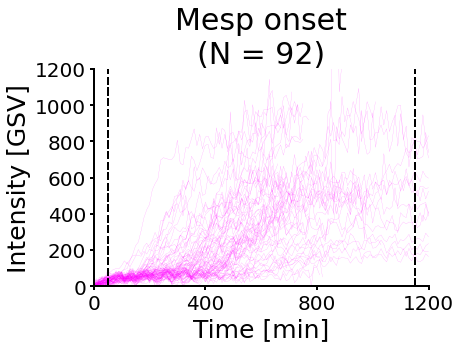

In [14]:
# Plot all Mesp tracks for each experiment separately

# Define the dimensions of the subplot

# Initialize the figure size
fig = plt.figure(figsize=[6,4])
   
window = 5

n_cells = len(intensities_mesp)


# Save the initial mean values per each experiment to later detrend
mean_vals_exp = []

# Save the last peak values in minutes
last_peak_lp = []

# To know how many mesp we have and how many meso traces we will actually use
mesp_counter = 0
mesp_all_counter = 0

# For plotting: mesp traces starting on a similar region and normalized by max
intensities_mesp_lp_plot = []
intensities_mesp_lp = []
for j in range(n_cells):
    
    aux = []

    # Mesp traces
    intensities = intensities_mesp[j]

    # Save values of mesp
    intensities_mesp_lp.append(intensities)
    last_peak_lp.append(last_peak_her1[j]) # This is already in minutes!

    # Save cropped values of mesp
    intensities_mesp_lp_plot.append((intensities-np.min(intensities)))

    plt.plot(intensities-np.min(intensities),
             color='magenta', linewidth=0.2, alpha=0.5)

    plt.xticks(np.arange(0,1600,400)/tr, np.arange(0,1600,400), fontsize=20)
    plt.xlim([0,120])
    plt.yticks(fontsize=20)
    plt.ylim([0,1200])
    plt.xlabel('Time [min]', fontsize=25)
    plt.ylabel('Intensity [GSV]', fontsize=25)

    plt.axvline(window, color='black', linewidth=2, linestyle='--')
    plt.axvline(120-window, color='black', linewidth=2, linestyle='--')

    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)
            
plt.title('Mesp onset\n(N = %d)'%(len(intensities_mesp_lp_plot)), fontsize=30)        
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespTraces-Cropped.pdf', format='pdf', bbox_inches='tight')

### Calculate Mesp Fold Change

<a id='fold'></a>


If you want to go to the top of the notebook click here: [Top](#top)

In [15]:
# How many points to take into account for the average of Area 1 and 2

def ratio_mesp(window, intensities):
        
    # Compute the areas
    area1 = np.abs(np.mean(intensities[:window]))
    area2 = np.mean(intensities[-window:])

    # Compute the fold change
    ratio = area2 - area1
    
    return ratio

# Compute the fold change: Area 2 - Area 1 
ratio = []
window = 5

for i in range(len(intensities_mesp_lp)):
       
        # Intensity values of Mesp tracks
        intensities = intensities_mesp_lp[i]

        ratio.append(ratio_mesp(window, intensities))
    

### Mesp fold change distribution

<a id='fold_dist'></a>


If you want to go to the top of the notebook click here: [Top](#top)

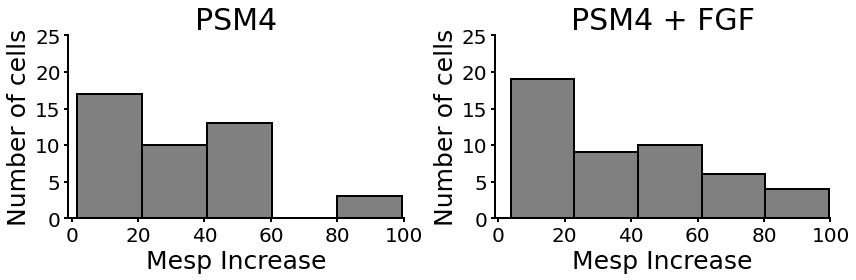

In [16]:
ratio_psm4 = np.array(ratio)[np.where(np.array(label)=='psm4')[0]]
ratio_fgf = np.array(ratio)[np.where(np.array(label)=='fgf')[0]]

last_peak_psm4 = np.array(last_peak_her1)[np.where(np.array(label)=='psm4')[0]]
last_peak_fgf = np.array(last_peak_her1)[np.where(np.array(label)=='fgf')[0]]

# Distributions
fig = plt.figure(figsize=[12,4])

plt.subplot(121)

plt.hist(ratio_psm4, edgecolor='black', color='gray', bins='fd', linewidth=2)
plt.title('PSM4', fontsize=30)
plt.xlabel('Mesp Increase', fontsize=25)
plt.ylabel('Number of cells', fontsize=25)
plt.xticks(np.arange(0,1200,200), np.arange(0,120,20), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-10,1000])
plt.ylim([0,25])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

plt.hist(ratio_fgf, edgecolor='black', color='gray', bins='fd', linewidth=2)
plt.title('PSM4 + FGF', fontsize=30)
plt.xlabel('Mesp Increase', fontsize=25)
plt.ylabel('Number of cells', fontsize=25)
plt.xticks(np.arange(0,1200,200), np.arange(0,120,20), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-10,1000])
plt.ylim([0,25])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()

plt.show()
fig.savefig('../Data/FGF/Results/FoldChangeMesp-LastPeak.pdf', format='pdf', bbox_inches='tight')

### Threshold Distribution using the Fold Change

<a id='threshold'></a>
Choosing different threshold values, check which is the distribution of Mesp Onset. 


If you want to go to the top of the notebook click here: [Top](#top)

In [17]:
# Number of thresholds for distribution
N = 10

# Threshold arrays
threshold_psm4 = np.linspace(np.min(ratio_psm4), np.max(ratio_psm4), N)
threshold_fgf = np.linspace(np.min(ratio_fgf), np.max(ratio_fgf), N)

# Save the distribution
dist_psm4 = np.zeros(N)
dist_fgf = np.zeros(N)

for i, val in enumerate(threshold_fgf):
    count = [j for j in range(len(ratio_fgf)) if ratio_fgf[j]>val]
    dist_fgf[i] = (len(count)/label.count('fgf'))*100
    
for i, val in enumerate(threshold_psm4):
    count = [j for j in range(len(ratio_psm4)) if ratio_psm4[j]>val]
    dist_psm4[i] = (len(count)/label.count('psm4'))*100

In [18]:
print('Min and max values of the threshold for FGF:', min(threshold_fgf), max(threshold_fgf))

print('Min and max values of the threshold for PSM4:', min(threshold_psm4), max(threshold_psm4))

Min and max values of the threshold for FGF: 37.48474822675291 1378.9630672069993
Min and max values of the threshold for PSM4: 15.248217718031356 995.7461985357188


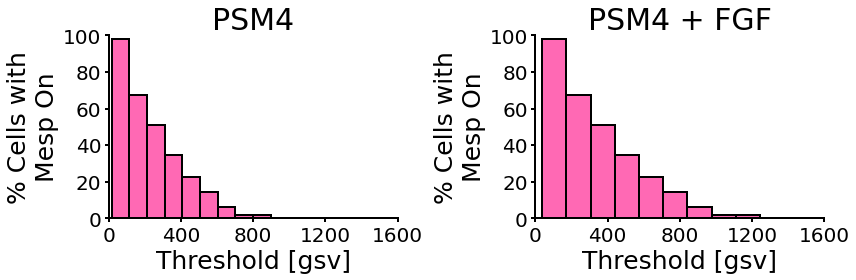

In [19]:
fig = plt.figure(figsize=[12,4])

plt.subplot(121)
plt.hist(threshold_psm4, edgecolor='black', color='hotpink', weights=dist_fgf, bins=N, linewidth=2)
plt.xticks(np.arange(0,2000, 400), fontsize=20);

plt.title('PSM4', fontsize=30)
plt.ylabel('% Cells with\nMesp On', fontsize=25)
plt.xlabel('Threshold [gsv]', fontsize=25)
plt.yticks(fontsize=20)
plt.ylim([0, 100])
plt.xlim([0, 1600])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
plt.hist(threshold_fgf, edgecolor='black', color='hotpink', weights=dist_fgf, bins=N, linewidth=2)
plt.xticks(np.arange(0,2000, 400), fontsize=20);

plt.title('PSM4 + FGF', fontsize=30)
plt.ylabel('% Cells with\nMesp On', fontsize=25)
plt.xlabel('Threshold [gsv]', fontsize=25)
plt.yticks(fontsize=20)
plt.ylim([0, 100])
plt.xlim([0, 1600])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

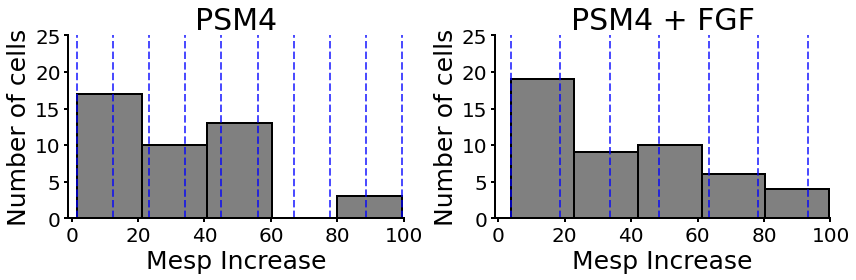

In [20]:
ratio_psm4 = np.array(ratio)[np.where(np.array(label)=='psm4')[0]]
ratio_fgf = np.array(ratio)[np.where(np.array(label)=='fgf')[0]]

# Distributions
fig = plt.figure(figsize=[12,4])

plt.subplot(121)

plt.hist(ratio_psm4, edgecolor='black', color='gray', bins='fd', linewidth=2)
for i in threshold_psm4:
    plt.axvline(i, color='blue', linewidth=2, linestyle='dashed', alpha=0.7)
plt.title('PSM4', fontsize=30)
plt.xlabel('Mesp Increase', fontsize=25)
plt.ylabel('Number of cells', fontsize=25)
plt.xticks(np.arange(0,1200,200), np.arange(0,120,20), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-10,1000])
plt.ylim([0,25])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

plt.hist(ratio_fgf, edgecolor='black', color='gray', bins='fd', linewidth=2)
for i in threshold_fgf:
    plt.axvline(i, color='blue', linewidth=2, linestyle='dashed', alpha=0.7)
plt.title('PSM4 + FGF', fontsize=30)
plt.xlabel('Mesp Increase', fontsize=25)
plt.ylabel('Number of cells', fontsize=25)
plt.xticks(np.arange(0,1200,200), np.arange(0,120,20), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-10,1000])
plt.ylim([0,25])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

### Threshold Distribution using the Mesp Intensities

<a id='traces_dist'></a>

Choosing different threshold values, check which is the distribution of Mesp Onset. 


If you want to go to the top of the notebook click here: [Top](#top)

In [21]:
inds = np.where(np.array(label)=='psm4')[0]
intensities_psm4 = np.array(intensities_mesp, dtype=object)[inds].tolist()

# Calculate minimum and maximum psm4 values
min_psm4 = np.inf
max_psm4 = 0
for i in range(len(inds)):
    if np.min(intensities_psm4[i])<min_psm4:
        min_psm4 = np.min(intensities_psm4[i])
            
    if np.max(intensities_psm4[i])>max_psm4:
        max_psm4 = np.max(intensities_psm4[i])
        
inds = np.where(np.array(label)=='fgf')[0]
intensities_fgf = np.array(intensities_mesp, dtype=object)[inds].tolist()

# Calculate minimum and maximum fgf values
min_fgf = np.inf
max_fgf = 0
for i in range(len(inds)):
    if np.min(intensities_fgf[i])<min_fgf:
        min_fgf = np.min(intensities_fgf[i])
        
    if np.max(intensities_fgf[i])>max_fgf:
        max_fgf = np.max(intensities_fgf[i])

In [22]:
# Number of thresholds for distribution
N = 10

# Threshold arrays
threshold_psm4 = np.linspace(800, 2000, N)
threshold_fgf = np.linspace(800, 2000, N)

# Save the distribution
dist_psm4 = np.zeros(N)
dist_fgf = np.zeros(N)

for i, val in enumerate(threshold_fgf):
    count = [j for j in range(len(intensities_fgf)) if np.max(intensities_fgf[j])>val]
    dist_fgf[i] = (len(count)/label.count('fgf'))*100
    
for i, val in enumerate(threshold_psm4):
    count = [j for j in range(len(intensities_psm4)) if np.max(intensities_psm4[j])>val]
    dist_psm4[i] = (len(count)/label.count('psm4'))*100

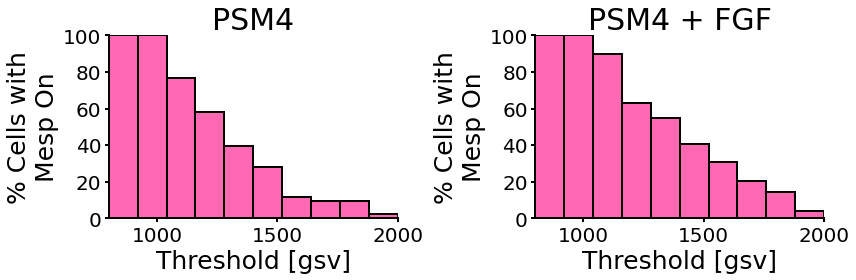

In [23]:
fig = plt.figure(figsize=[12,4])

plt.subplot(121)
plt.hist(threshold_psm4, edgecolor='black', color='hotpink', weights=dist_psm4, bins=N, linewidth=2)
plt.xticks(np.arange(0,3500, 500), fontsize=20);

plt.title('PSM4', fontsize=30)
plt.ylabel('% Cells with\nMesp On', fontsize=25)
plt.xlabel('Threshold [gsv]', fontsize=25)
plt.yticks(fontsize=20)
plt.ylim([0, 100])
plt.xlim([800, 2000])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
plt.hist(threshold_fgf, edgecolor='black', color='hotpink', weights=dist_fgf, bins=N, linewidth=2)
plt.xticks(np.arange(0,3500, 500), fontsize=20);

plt.title('PSM4 + FGF', fontsize=30)
plt.ylabel('% Cells with\nMesp On', fontsize=25)
plt.xlabel('Threshold [gsv]', fontsize=25)
plt.yticks(fontsize=20)
plt.ylim([0, 100])
plt.xlim([800, 2000])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

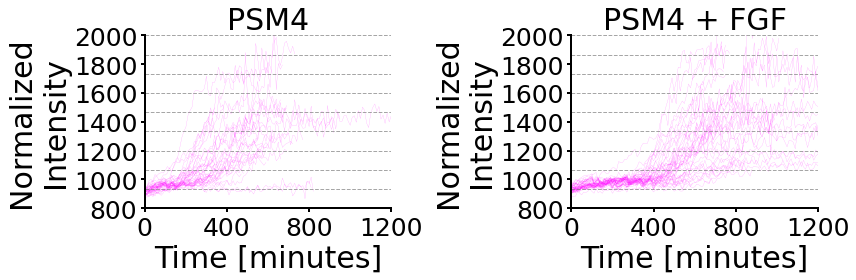

In [24]:
fig = plt.figure(figsize=[12,4])

plt.subplot(121)

inds = np.where(np.array(label)=='psm4')[0]
for i in inds:
    plt.plot(np.arange(len(intensities_mesp[i]))*tr, intensities_mesp[i],
            color = 'magenta', linewidth=0.2, alpha=0.5)

for j in threshold_psm4:
    plt.axhline(j, linestyle='dashed', color='grey', linewidth=1, alpha=0.7)
    
plt.xlim([0,1200])
plt.ylim([800, 2000])
plt.title('PSM4', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
inds = np.where(np.array(label)=='fgf')[0]

for i in inds:
    plt.plot(np.arange(len(intensities_mesp[i]))*tr, intensities_mesp[i],
            color = 'magenta', linewidth=0.2, alpha=0.5)
    
for j in threshold_fgf:
    plt.axhline(j, linestyle='dashed', color='grey', linewidth=1, alpha=0.7)
    
plt.xlim([0,1200])
plt.ylim([800, 2000])
plt.title('PSM4 + FGF', fontsize=30)
plt.xticks(np.arange(0,1600,400), fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time [minutes]', fontsize=30)
plt.ylabel('Normalized\nIntensity', fontsize=30)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

## Perform the Fold Change distributions for her1 and Mesp

### Classify Mesp fold change values

<a id='classify'></a>

In order to make the distributions to observe how is the Mesp onset with respect the last peak of her 1, we first need to classify the fold change (which we calculated above) in terms of how high is this fold change. In the end, for the distribution analysis, we will only be using cells which have a clear Mesp onset. Which is why, in the following lines we will first classify using supervised machine learning algorthm K-Means to cluster the Mesp Fold Change values. 


If you want to go to the top of the notebook click here: [Top](#top)

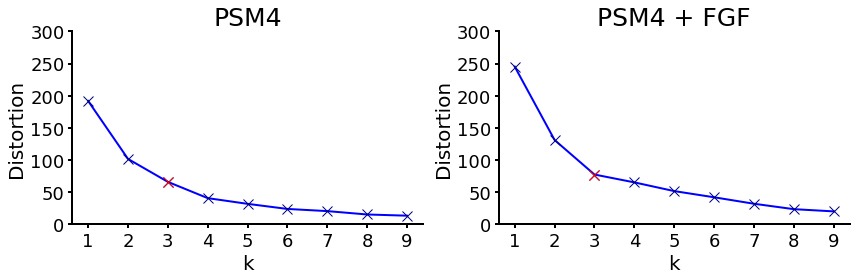

In [25]:
# k means determine k: ELBOW METHOD
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

fig = plt.figure(figsize=[12,4])

plt.subplot(121)

distortions = []
K = range(1,10)

# Define the data
X = np.array(ratio_psm4).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=100).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2, markersize=10,  mec='navy')
plt.plot(3, distortions[2], 'bx-', linewidth=6, markersize=10,  mec='red')
plt.xlabel('k', fontsize=20)
plt.ylabel('Distortion', fontsize=20)
plt.title('PSM4', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0, 300])
#plt.title('The Elbow Method showing the optimal k', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)

distortions = []
K = range(1,10)

# Define the data
X = np.array(ratio_fgf).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=100).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2, markersize=10,  mec='navy')
plt.plot(3, distortions[2], 'bx-', linewidth=6, markersize=10,  mec='red')
plt.xlabel('k', fontsize=20)
plt.ylabel('Distortion', fontsize=20)
plt.title('PSM4 + FGF', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0, 300])
#plt.title('The Elbow Method showing the optimal k', fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
    
plt.tight_layout()
plt.show()

fig.savefig('../Data/FGF/Results/ElbowMethod.pdf', bbox_inches='tight')

## Mesp Onset using all the cells

<a id='onset_all'></a>


If you want to go to the top of the notebook click here: [Top](#top)

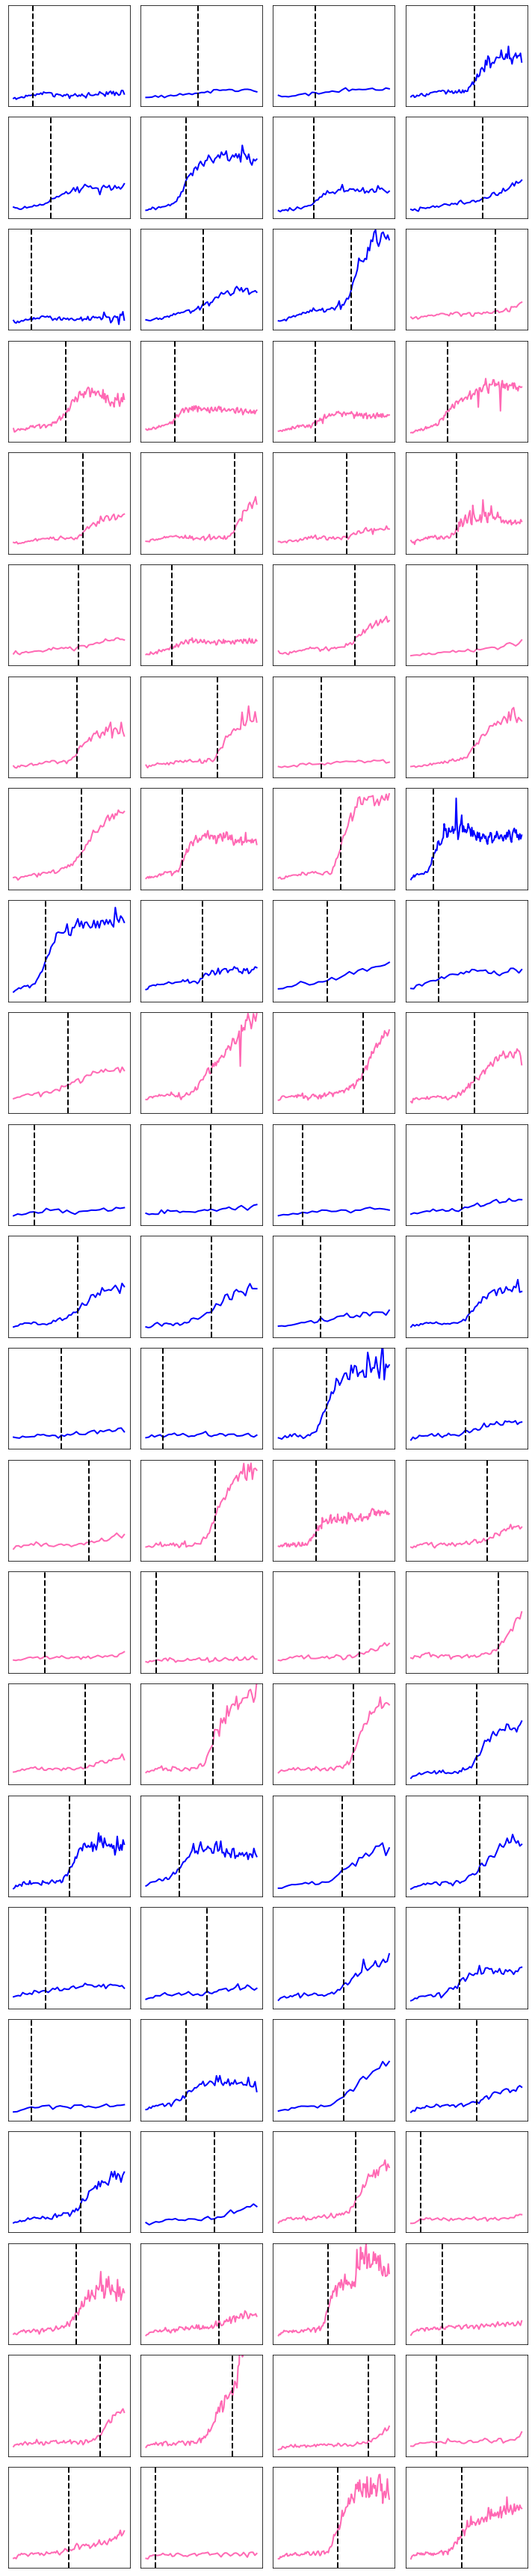

In [26]:
lag_window = 5
color = ['blue', 'hotpink']

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((len(intensities_mesp_lp) + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])
onset_mesp_all = []

onset_mesp_psm4 = []
onset_mesp_fgf = []

onset_mesp_psm4_seed = []
onset_mesp_fgf_seed = []

for i in range(len(intensities_mesp_lp)):

    X = np.zeros((len(intensities_mesp_lp[i][window:]),2))
    X[:,0] = intensities_mesp_lp[i][window:]
    X[:,1] = intensities_mesp_lp[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)


    ind_cut = np.where(y_pred[lag_window:]==y_pred[-1])[0]+lag_window
    onset_mesp_all.append(ind_cut[0])
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    if label[i]=='psm4':
        plt.plot(intensities_mesp_lp[i], color=color[0], linewidth=2)
        onset_mesp_psm4.append(ind_cut[0])
        onset_mesp_psm4_seed.append(ind_cut[0]+seed_times_use[i]/tr)
    if label[i]=='fgf':
        plt.plot(intensities_mesp_lp[i], color=color[1], linewidth=2)
        onset_mesp_fgf.append(ind_cut[0])
        onset_mesp_fgf_seed.append(ind_cut[0]+seed_times_use[i]/tr)
         
    plt.axvline(ind_cut[0], color='black', linestyle='dashed', linewidth=2)

    plt.xticks([])
    #plt.xlim([0,45])
    plt.ylim([800,2000])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

### Mesp Onset Timing

<a id='onset_timing_dist'></a>


If you want to go to the top of the notebook click here: [Top](#top)

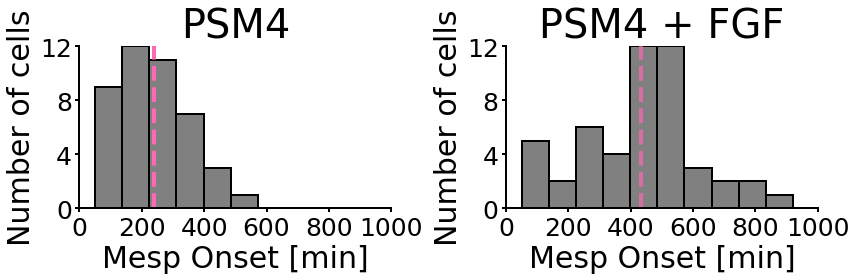

In [27]:
plt.figure(figsize=[12,4])

# Same bin size
bins=np.histogram(np.hstack((np.array(onset_mesp_psm4)*tr, np.array(onset_mesp_fgf)*tr)), bins=10)[1] #get the bin edges

plt.subplot(121)
plt.hist(np.array(onset_mesp_psm4)*tr, bins=bins, linewidth=2, edgecolor='k', color='grey');
plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.axvline(np.mean(onset_mesp_psm4)*tr, color='hotpink', linewidth=4, linestyle='--', alpha=1)
plt.xticks(np.arange(0,1200,200),fontsize=25)
plt.yticks(np.arange(0,14,4), fontsize=25)
plt.ylim([0,12])
plt.ylabel('Number of cells',fontsize=30)
plt.title('PSM4', fontsize=40)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
plt.hist(np.array(onset_mesp_fgf)*tr, bins=bins, linewidth=2, edgecolor='black', color='grey');
plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.axvline(np.mean(onset_mesp_fgf)*tr, color='hotpink', linewidth=4, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0,1200,200),fontsize=25)
plt.yticks(np.arange(0,14,4), fontsize=25)
plt.ylim([0,12])
plt.ylabel('Number of cells',fontsize=30)
plt.title('PSM4 + FGF', fontsize=40)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

In [28]:
print(f'PSM4: Mean +- SD = {np.mean(onset_mesp_psm4)*tr:.2f} +- {np.std(onset_mesp_psm4)*tr:.2f}') 
print(f'PSM4 + FGF: Mean +- SD = {np.mean(onset_mesp_fgf)*tr:.2f} +- {np.std(onset_mesp_fgf)*tr:.2f}') 

PSM4: Mean +- SD = 239.30 +- 120.57
PSM4 + FGF: Mean +- SD = 434.08 +- 189.84


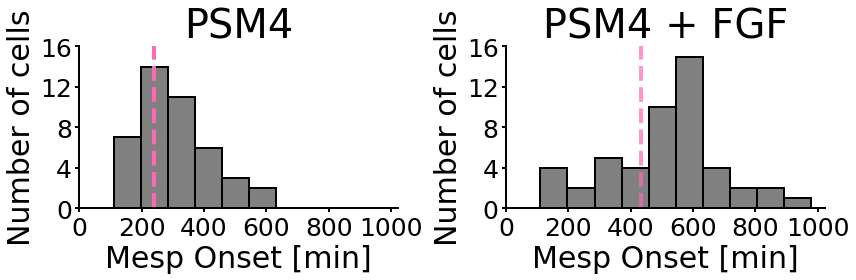

In [29]:
plt.figure(figsize=[12,4])

# Same bin size
bins=np.histogram(np.hstack((np.array(onset_mesp_psm4_seed)*tr, np.array(onset_mesp_fgf_seed)*tr)), bins=10)[1] #get the bin edges

plt.subplot(121)
plt.hist(np.array(onset_mesp_psm4_seed)*tr, bins=bins, linewidth=2, edgecolor='k', color='grey');
plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.axvline(np.mean(onset_mesp_psm4)*tr, color='hotpink', linewidth=4, linestyle='--', alpha=1)
plt.xticks(np.arange(0,1200,200),fontsize=25)
plt.yticks(np.arange(0,20,4), fontsize=25)
plt.ylim([0,16])
plt.ylabel('Number of cells',fontsize=30)
plt.title('PSM4', fontsize=40)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
plt.hist(np.array(onset_mesp_fgf_seed)*tr, bins=bins, linewidth=2, edgecolor='black', color='grey');
plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.axvline(np.mean(onset_mesp_fgf)*tr, color='hotpink', linewidth=4, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0,1200,200),fontsize=25)
plt.yticks(np.arange(0,20,4), fontsize=25)
plt.ylim([0,16])
plt.ylabel('Number of cells',fontsize=30)
plt.title('PSM4 + FGF', fontsize=40)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

In [30]:
print(f'PSM4: Mean +- SD = {np.mean(onset_mesp_psm4_seed)*tr:.2f} +- {np.std(onset_mesp_psm4_seed)*tr:.2f}') 
print(f'PSM4 + FGF: Mean +- SD = {np.mean(onset_mesp_fgf_seed)*tr:.2f} +- {np.std(onset_mesp_fgf_seed)*tr:.2f}') 

PSM4: Mean +- SD = 307.21 +- 120.91
PSM4 + FGF: Mean +- SD = 504.49 +- 188.63


### Classify using K-Means

#### PSM4

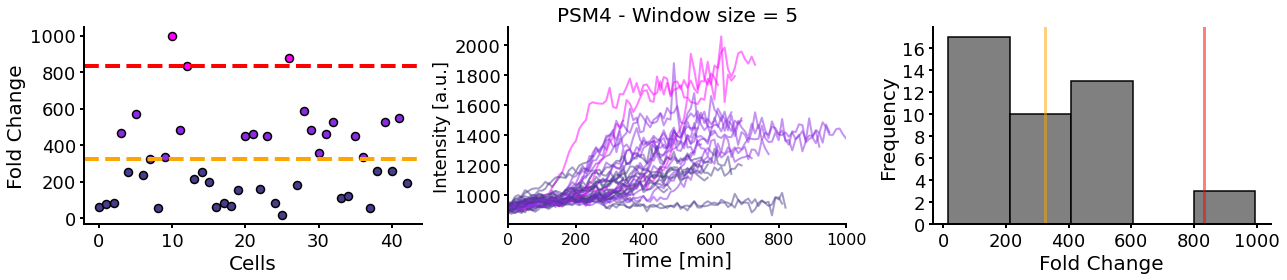

In [31]:
# Distributions

fig = plt.figure(figsize=[18,4])
plt.style.use('default')

n_clusters = 3

plt.subplot(131)
# Calculate the percentage of Mesp on cells

# Remove nans
ratio1_ = np.array(ratio_psm4)
    
color = ['darkslateblue', 'magenta', 'blueviolet']
# Use the same seed to avoid changing clusters 
# Define the data
X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred1 = KMeans(n_clusters=n_clusters, n_init=200, random_state=25).fit_predict(X)

group1 = np.where(y_pred1==1)[0]
group2 = np.where(y_pred1==2)[0]
group3 = np.where(y_pred1==0)[0]

val1 = np.min(ratio1_[group1])
val2 = np.min(ratio1_[group2])
val3 = np.min(ratio1_[group3])

th1 = np.mean(ratio1_<= val1)*100
th2 = np.mean(ratio1_<= val2)*100
th3 = np.mean(ratio1_<= val3)*100

for i in range(len(X)):
    plt.plot(i, X[i], 'o', markersize=8, markerfacecolor=color[y_pred1[i]], markeredgewidth=1.5, markeredgecolor='black')

plt.axhline(val1, color='red', linewidth=4, linestyle='--')
plt.axhline(val2, color='orange', linewidth=4, linestyle='--')
#plt.axhline(val3, color='gold', linewidth=2, linestyle='--')

plt.xlabel('Cells', fontsize=20)
plt.ylabel('Fold Change', fontsize=20)
#plt.ylim([-10,110])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(132)
count = 0
for i in range(len(intensities_mesp_lp)): 
    if label[i]=='psm4':
        plt.plot(intensities_mesp_lp[i], c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
        count+=1
        
plt.xlabel('Time [min]',fontsize=20)
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 120, 20), np.arange(0,1200,200),fontsize=16)
plt.xlim([0,100])
plt.yticks(fontsize=18)
plt.ylabel('Intensity [a.u.]',fontsize=18)
plt.title('PSM4 - Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(133)

plt.hist(ratio1_, edgecolor='black', color='grey', bins='fd', linewidth=1.5)
plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
plt.axvline(val2, color='orange', linewidth=3, alpha=0.5)
#plt.axvline(val3, color='gold', linewidth=3, alpha=0.5)

plt.xlabel('Fold Change', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()

plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans.pdf', format='pdf', bbox_inches='tight')

In [32]:
print('Percentage of cells in group 1: %.2f'%(len(group1)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 2: %.2f'%(len(group2)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 3: %.2f'%(len(group3)*100/sum([len(group1),len(group2),len(group3)])))

Percentage of cells in group 1: 6.98
Percentage of cells in group 2: 39.53
Percentage of cells in group 3: 53.49


In [33]:
print('Percentage of cells with Mesp ON in PSM4 cells: %.2f'%(6.98+39.53))

Percentage of cells with Mesp ON in PSM4 cells: 46.51


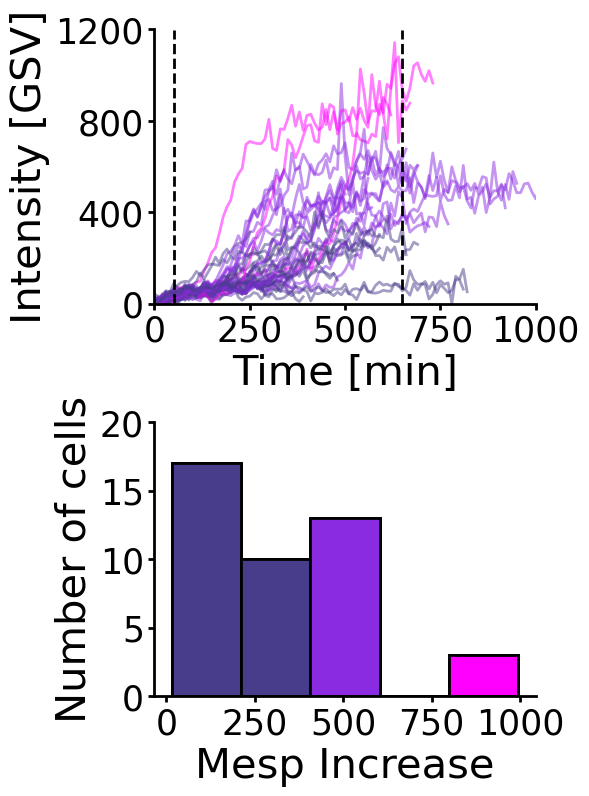

In [34]:
# Distributions

fig = plt.figure(figsize=[6,8])
color = ['darkslateblue', 'magenta', 'blueviolet']
n_clusters = 3

plt.subplot(211)
window = 5
count = 0
for i in range(len(intensities_mesp_lp)):   
    if label[i]=='psm4':
        plt.plot(intensities_mesp_lp[i]-np.min(intensities_mesp_lp[i]),
                 c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
        count+=1
        
plt.axvline(window, color='black', linewidth=2, linestyle='--')
plt.axvline(70-window, color='black', linewidth=2, linestyle='--')
plt.xlabel('Time [min]',fontsize=30)
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 125, 25),  np.arange(0, 125, 25)*tr, fontsize=25)
plt.xlim([0,100])
plt.yticks(np.arange(0,1500,400), fontsize=25)
plt.ylim([0,1200])
plt.ylabel('Intensity [GSV]',fontsize=30)
#plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(212)

plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
#plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
#plt.axvline(val2, color='red', linewidth=3, alpha=0.5)
N, bins, patches = plt.hist(ratio1_, edgecolor='black', linewidth=2, bins='fd')
#plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
ind1 = np.argmin((val1-bins)**2)
ind2 = np.argmin((val2-bins)**2)

for i in range(0,ind2):
    patches[i].set_facecolor(color[0])
for i in range(ind2,ind1):    
    patches[i].set_facecolor(color[2])
for i in range(ind1, len(patches)):
    patches[i].set_facecolor(color[1])

plt.xlabel('Mesp Increase', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.xticks(np.arange(0,1250, 250), fontsize=25)
plt.yticks(np.arange(0,25,5), fontsize=25)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.tight_layout()
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans-FoldChangeMesp.pdf', format='pdf', bbox_inches='tight')

### In cells with with Mesp on, when is this happening?

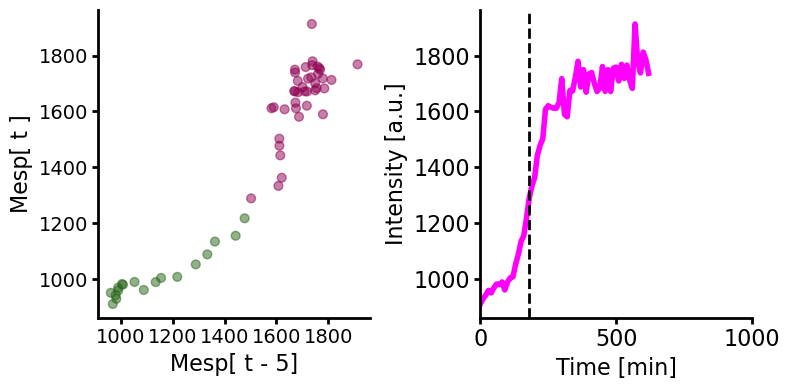

In [35]:
i = np.where(y_pred1==1)[0][1]

X = np.zeros((len(intensities_psm4[i][window:]),2))
X[:,0] = intensities_psm4[i][window:]
X[:,1] = intensities_psm4[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=0.5,cmap='PiYG',s=40)

plt.xticks(fontsize=14)
#plt.xlim([500,1500])
plt.yticks(fontsize=14)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=16)
plt.ylabel('Mesp[ t ]', fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(intensities_psm4[i], color='magenta', linewidth=4)
plt.axvline(ind_cut[0], color='black', linewidth=2, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,175,50), np.arange(0,175,50)*tr, fontsize=16)
plt.xlim([0,100])
plt.yticks(fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ExampleCell-MespOnset.pdf', format='pdf', bbox_inches='tight')

#### Show Mesp Onset for each individual cell

The colors are according to the group they belong which was calculated using K-Means Clustering (above figures) with 3 different clusters. 

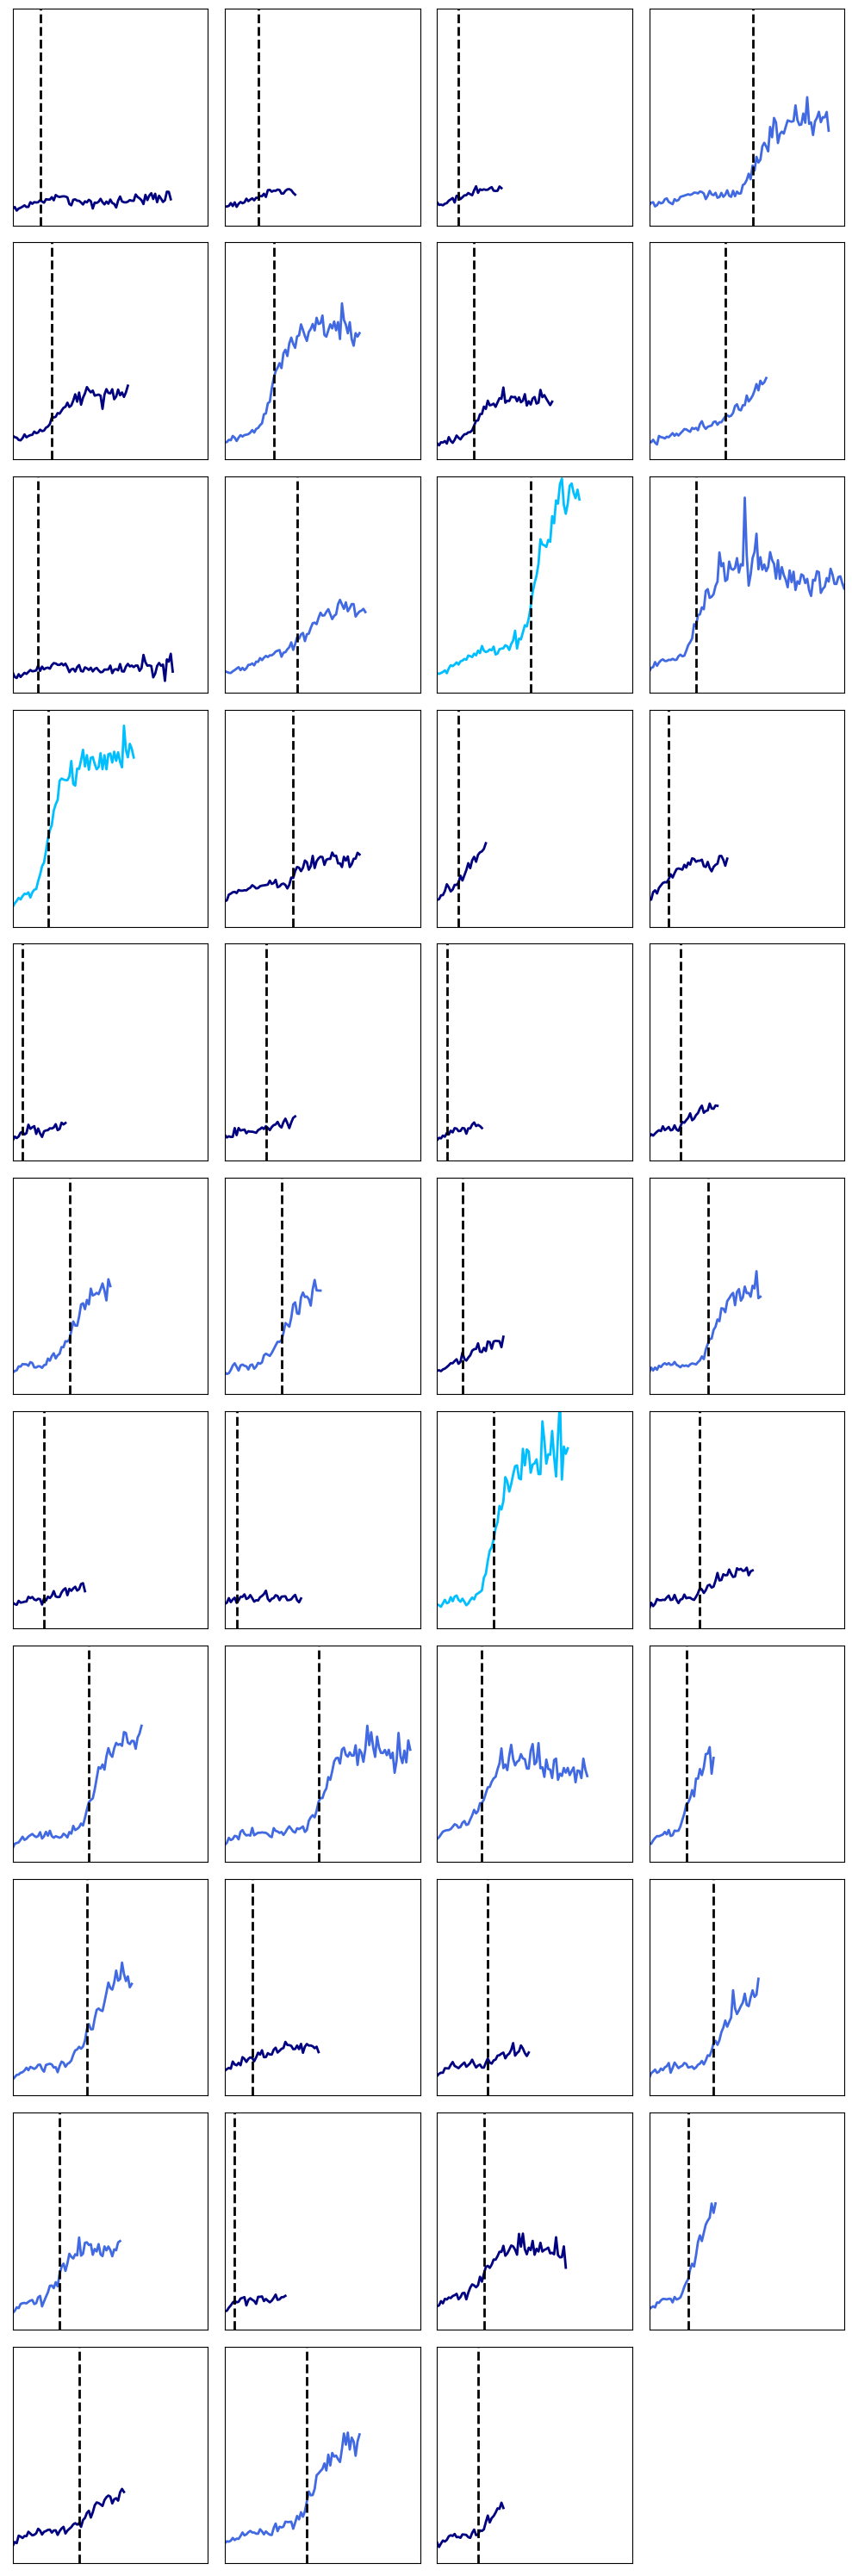

In [36]:
lag_window = 5
color = ['navy', 'deepskyblue', 'royalblue', 'aqua']

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((len(intensities_psm4) + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,30])
onset_mesp_all = []

for i in range(len(intensities_psm4)):
    X = np.zeros((len(intensities_psm4[i][window:]),2))
    X[:,0] = intensities_psm4[i][window:]
    X[:,1] = intensities_psm4[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)


    ind_cut = np.where(y_pred[lag_window:]==y_pred[-1])[0]+lag_window
    onset_mesp_all.append(ind_cut[0])
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    plt.plot(intensities_psm4[i], color=color[y_pred1[i]], linewidth=2)
    plt.axvline(ind_cut[0], color='black', linestyle='dashed', linewidth=2)

    plt.xticks([])
    plt.xlim([0,100])
    plt.ylim([800,2000])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

## Take only the Mesp Onsets with the highest mesp fold changes

We previously classified the Mesp fold change using K-means and we obtained 3 different groups. We are now only going to use the two groups which have the highes Mesp fold change values in order to quantify the time of this onset. 

In [37]:
window = 5

X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=26).fit_predict(X)

# Find the maximum fold change for each group
max1 = np.max(ratio1_[np.where(y_pred==0)[0]])
max2 = np.max(ratio1_[np.where(y_pred==1)[0]])
max3 = np.max(ratio1_[np.where(y_pred==2)[0]])

# Find the two groups where the fold change is highest
inds = np.argsort([max1,max2,max3])[1:]

# Find the positions where those values are in the ratio
ind_mesp = np.concatenate((np.where(y_pred==inds[0])[0], \
                           np.where(y_pred==inds[1])[0]))

onset_mesp_psm4 = []
onset_lp_psm4 = []
for i in ind_mesp:

    X = np.zeros((len(intensities_psm4[i][window:]),2))
    X[:,0] = intensities_psm4[i][window:]
    X[:,1] = intensities_psm4[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

    ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
    onset_mesp_psm4.append(ind_cut[0]*tr)
    onset_lp_psm4.append(last_peak_psm4[i])

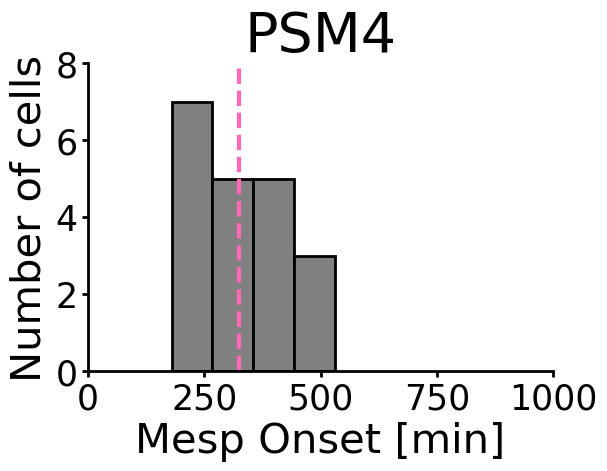

In [38]:
fig = plt.figure(figsize=[6,4])

onset_mesp = np.array(onset_mesp_psm4)

plt.hist(onset_mesp, bins='fd', linewidth=2, edgecolor='black', color='grey', alpha=1, density=False);
plt.axvline(np.mean(onset_mesp), linewidth=3, linestyle='dashed', color='hotpink')

plt.title('PSM4', fontsize=40)
plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.ylabel('Number of cells',fontsize=30)
plt.xticks(np.arange(0,1250,250), fontsize=25)
plt.yticks(np.arange(0,10,2), fontsize=25)
plt.xlim([0,1000])
plt.ylim([0,8])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()
#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespOnset.pdf', format='pdf', bbox_inches='tight')

In [39]:
print(f'Mean +- SD = {np.mean(onset_mesp):.2f} +- {np.std(onset_mesp):.2f}')

Mean +- SD = 323.50 +- 100.21


#### PSM4 + FGF

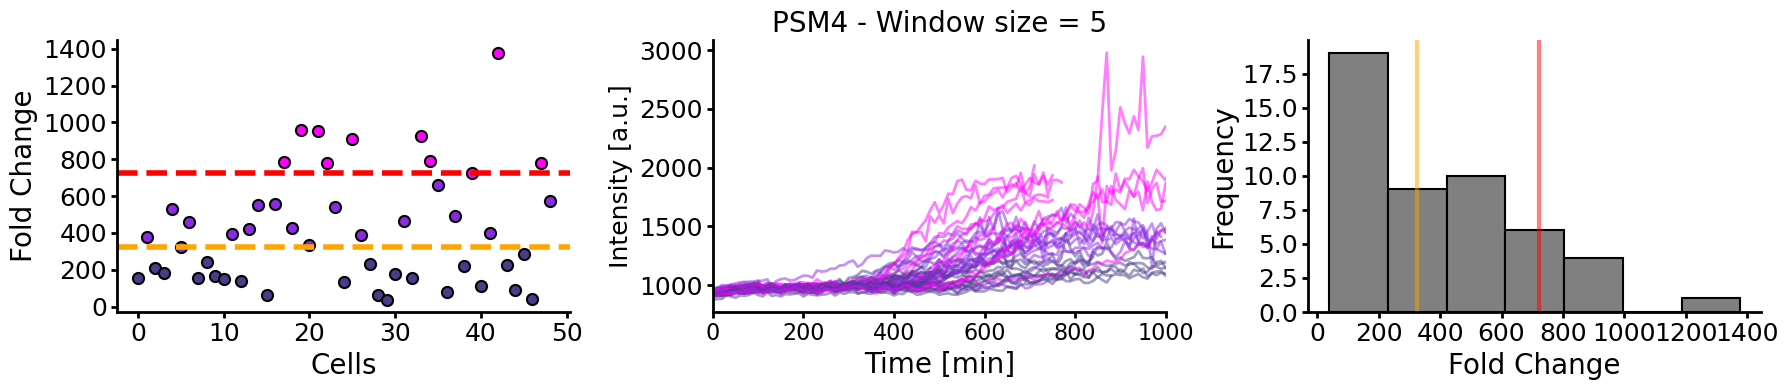

In [40]:
# Distributions

fig = plt.figure(figsize=[18,4])
plt.style.use('default')

n_clusters = 3

plt.subplot(131)
# Calculate the percentage of Mesp on cells

# Remove nans
ratio1_ = np.array(ratio_fgf)
    
color = ['darkslateblue', 'magenta', 'blueviolet']
# Use the same seed to avoid changing clusters 
# Define the data
X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan

y_pred1 = KMeans(n_clusters=n_clusters, n_init=200, random_state=4).fit_predict(X)

group1 = np.where(y_pred1==1)[0]
group2 = np.where(y_pred1==2)[0]
group3 = np.where(y_pred1==0)[0]

val1 = np.min(ratio1_[group1])
val2 = np.min(ratio1_[group2])
val3 = np.min(ratio1_[group3])

th1 = np.mean(ratio1_<= val1)*100
th2 = np.mean(ratio1_<= val2)*100
th3 = np.mean(ratio1_<= val3)*100

for i in range(len(X)):
    plt.plot(i, X[i], 'o', markersize=8, markerfacecolor=color[y_pred1[i]], markeredgewidth=1.5, markeredgecolor='black')

plt.axhline(val1, color='red', linewidth=4, linestyle='--')
plt.axhline(val2, color='orange', linewidth=4, linestyle='--')
#plt.axhline(val3, color='gold', linewidth=2, linestyle='--')

plt.xlabel('Cells', fontsize=20)
plt.ylabel('Fold Change', fontsize=20)
#plt.ylim([-10,110])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(132)
count = 0
for i in range(len(intensities_mesp_lp)): 
    if label[i]=='fgf':
        plt.plot(intensities_mesp_lp[i], c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
        count+=1
        
plt.xlabel('Time [min]',fontsize=20)
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 120, 20), np.arange(0,1200,200),fontsize=16)
plt.xlim([0,100])
plt.yticks(fontsize=18)
plt.ylabel('Intensity [a.u.]',fontsize=18)
plt.title('PSM4 - Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(133)

plt.hist(ratio1_, edgecolor='black', color='grey', bins='fd', linewidth=1.5)
plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
plt.axvline(val2, color='orange', linewidth=3, alpha=0.5)
#plt.axvline(val3, color='gold', linewidth=3, alpha=0.5)

plt.xlabel('Fold Change', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()

plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans.pdf', format='pdf', bbox_inches='tight')

In [41]:
print('Percentage of cells in group 1: %.2f'%(len(group1)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 2: %.2f'%(len(group2)*100/sum([len(group1),len(group2),len(group3)])))
print('Percentage of cells in group 3: %.2f'%(len(group3)*100/sum([len(group1),len(group2),len(group3)])))

Percentage of cells in group 1: 20.41
Percentage of cells in group 2: 34.69
Percentage of cells in group 3: 44.90


In [42]:
print('Percentage of cells with Mesp ON in PSM4 + FGF cells: %.2f'%(20.41+34.69))

Percentage of cells with Mesp ON in PSM4 + FGF cells: 55.10


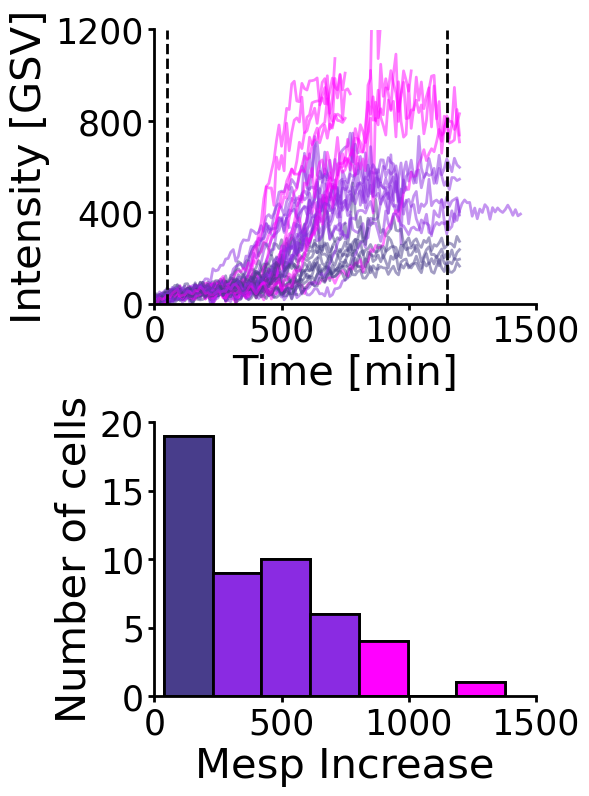

In [43]:
# Distributions

fig = plt.figure(figsize=[6,8])
color = ['darkslateblue', 'magenta', 'blueviolet']
n_clusters = 3

plt.subplot(211)
window = 5
count = 0
for i in range(len(intensities_mesp_lp)):   
    if label[i]=='fgf':
        plt.plot(intensities_mesp_lp[i]-np.min(intensities_mesp_lp[i]),
                 c=color[y_pred1[count]],alpha=0.5, linewidth=2) 
        count+=1
        
plt.axvline(window, color='black', linewidth=2, linestyle='--')
plt.axvline(120-window, color='black', linewidth=2, linestyle='--')
plt.xlabel('Time [min]',fontsize=30)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,175, 50), np.arange(0,1750, 500), fontsize=25)
plt.xlim([0,150])
plt.yticks(np.arange(0,1500,400), fontsize=25)
plt.ylim([0,1200])
plt.ylabel('Intensity [GSV]',fontsize=30)
#plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(212)

plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
#plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
#plt.axvline(val2, color='red', linewidth=3, alpha=0.5)
N, bins, patches = plt.hist(ratio1_, edgecolor='black', linewidth=2, bins='fd')
#plt.hist(ratio1_, edgecolor='black', color='gray', bins='fd', linewidth=2)
ind1 = np.argmin((val1-bins)**2)
ind2 = np.argmin((val2-bins)**2)

for i in range(0,ind2):
    patches[i].set_facecolor(color[0])
for i in range(ind2,ind1):    
    patches[i].set_facecolor(color[2])
for i in range(ind1, len(patches)):
    patches[i].set_facecolor(color[1])

plt.xlabel('Mesp Increase', fontsize=30)
plt.ylabel('Number of cells', fontsize=30)
plt.xticks(np.arange(0, 1750, 500), fontsize=25)
plt.xlim([0, 1500])
plt.yticks(np.arange(0,25,5), fontsize=25)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)


plt.tight_layout()
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ClusteredKMeans-FoldChangeMesp.pdf', format='pdf', bbox_inches='tight')

### In cells with with Mesp on, when is this happening?

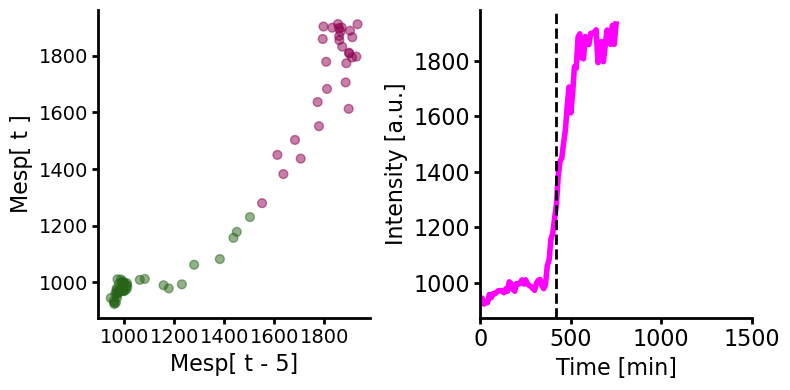

In [44]:
i = np.where(y_pred1==1)[0][1]

X = np.zeros((len(intensities_fgf[i][window:]),2))
X[:,0] = intensities_fgf[i][window:]
X[:,1] = intensities_fgf[i][:-window]
y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y_pred,alpha=0.5,cmap='PiYG',s=40)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Mesp[ t - %d]'%window, fontsize=16)
plt.ylabel('Mesp[ t ]', fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
ind_cut = np.where(y_pred[5:]==y_pred[-1])[0]+5
plt.plot(intensities_fgf[i], color='magenta', linewidth=4)
plt.axvline(ind_cut[0], color='black', linewidth=2, linestyle='dashed')

plt.xlabel('Time [min]',fontsize=16)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,175,50), np.arange(0,175,50)*tr, fontsize=16)
plt.xlim([0,150])
plt.yticks(fontsize=16)
plt.ylabel('Intensity [a.u.]',fontsize=16)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/ExampleCell-MespOnset.pdf', format='pdf', bbox_inches='tight')

#### Show Mesp Onset for each individual cell

The colors are according to the group they belong which was calculated using K-Means Clustering (above figures) with 3 different clusters. 

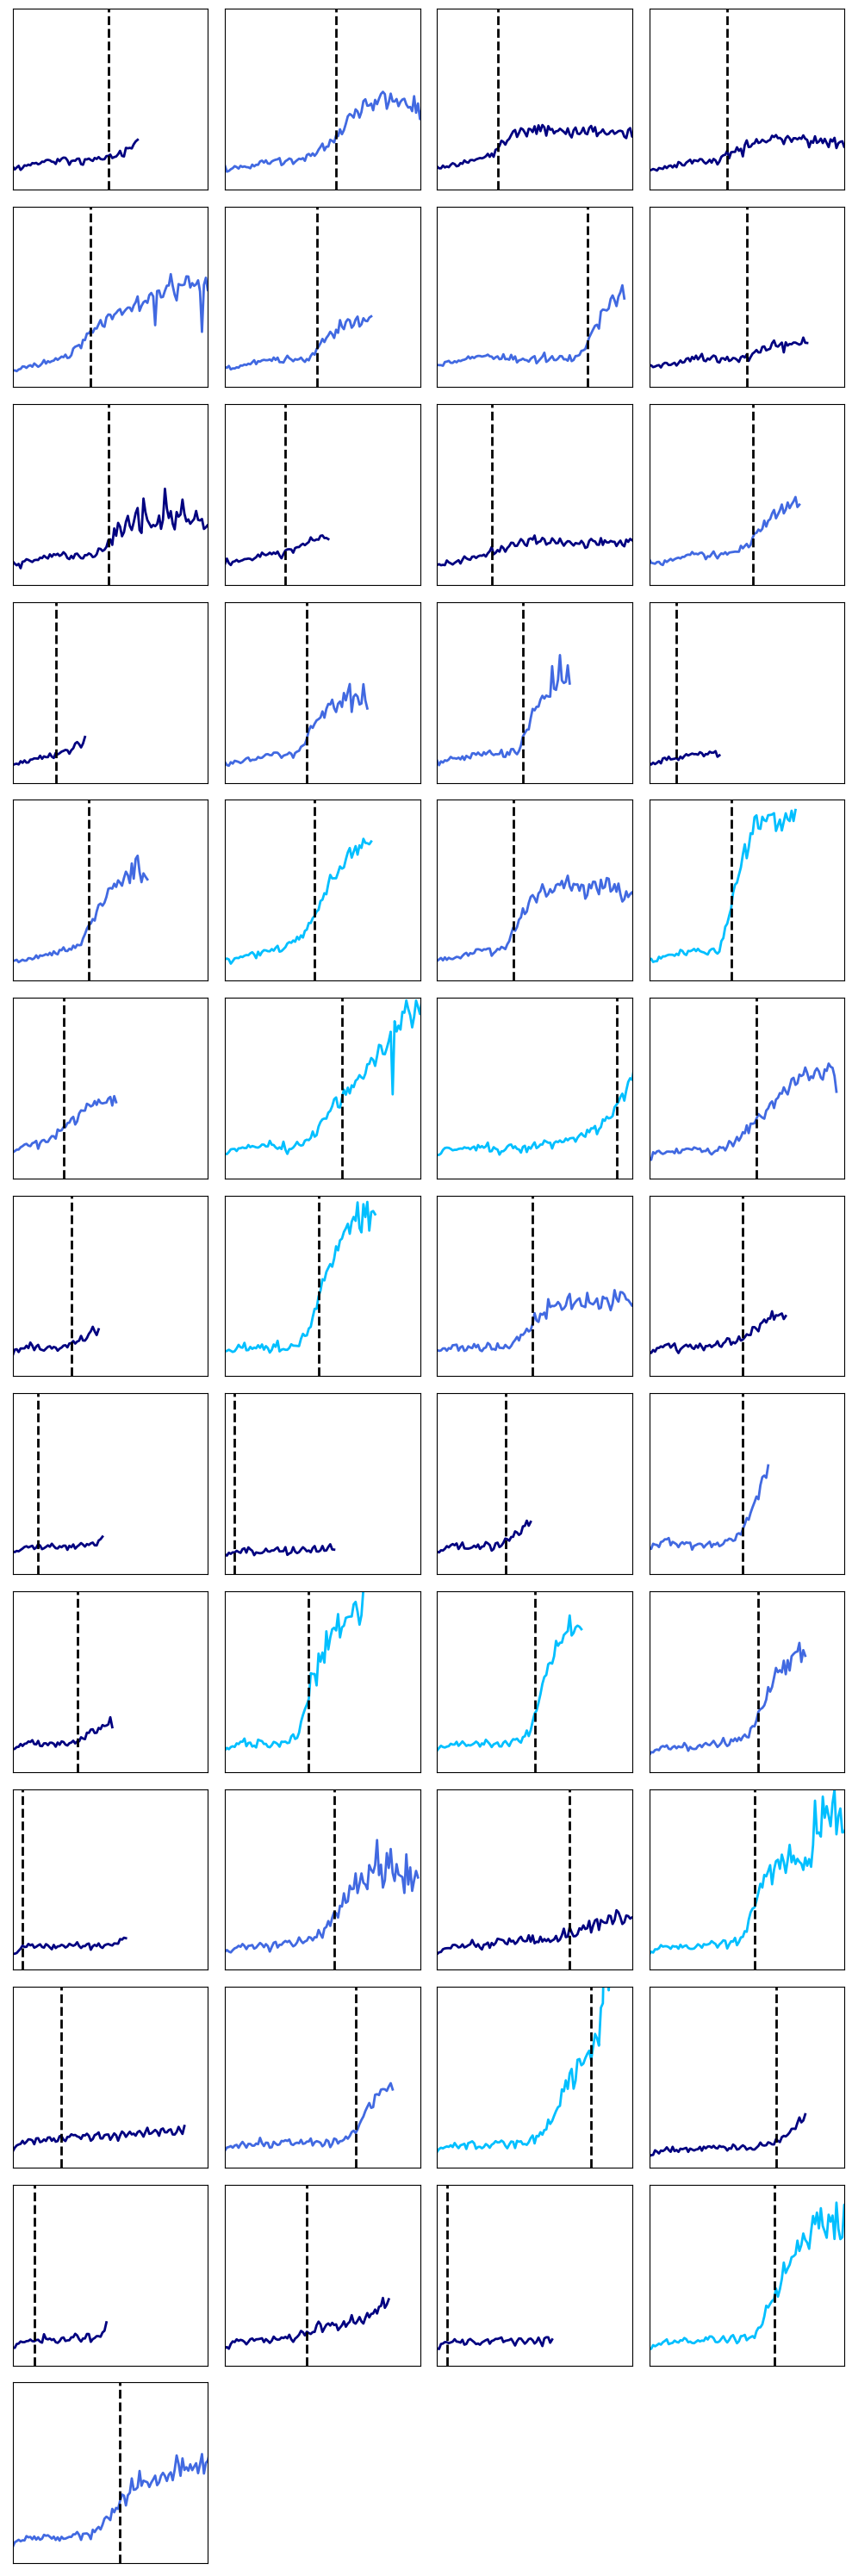

In [45]:
lag_window = 5
color = ['navy', 'deepskyblue', 'royalblue', 'aqua']

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((len(intensities_fgf) + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10, 30])
onset_mesp_all = []

for i in range(len(intensities_fgf)):
    X = np.zeros((len(intensities_fgf[i][window:]),2))
    X[:,0] = intensities_fgf[i][window:]
    X[:,1] = intensities_fgf[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)


    ind_cut = np.where(y_pred[lag_window:]==y_pred[-1])[0]+lag_window
    onset_mesp_all.append(ind_cut[0])
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    plt.plot(intensities_fgf[i], color=color[y_pred1[i]], linewidth=2)
    plt.axvline(ind_cut[0], color='black', linestyle='dashed', linewidth=2)

    plt.xticks([])
    plt.xlim([0,100])
    plt.ylim([800,2000])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

## Take only the Mesp Onsets with the highest mesp fold changes

We previously classified the Mesp fold change using K-means and we obtained 3 different groups. We are now only going to use the two groups which have the highes Mesp fold change values in order to quantify the time of this onset. 

In [46]:
window = 5

X = np.array(ratio1_).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=4).fit_predict(X)

# Find the maximum fold change for each group
max1 = np.max(ratio1_[np.where(y_pred==0)[0]])
max2 = np.max(ratio1_[np.where(y_pred==1)[0]])
max3 = np.max(ratio1_[np.where(y_pred==2)[0]])

# Find the two groups where the fold change is highest
inds = np.argsort([max1,max2,max3])[1:]

# Find the positions where those values are in the ratio
ind_mesp = np.concatenate((np.where(y_pred==inds[0])[0], \
                           np.where(y_pred==inds[1])[0]))

onset_mesp_fgf = []
onset_lp_fgf = []

for i in ind_mesp:

    X = np.zeros((len(intensities_fgf[i][window:]),2))
    X[:,0] = intensities_fgf[i][window:]
    X[:,1] = intensities_fgf[i][:-window]
    y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)

    ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
    onset_mesp_fgf.append(ind_cut[0]*tr)
    onset_lp_fgf.append(last_peak_fgf[i])

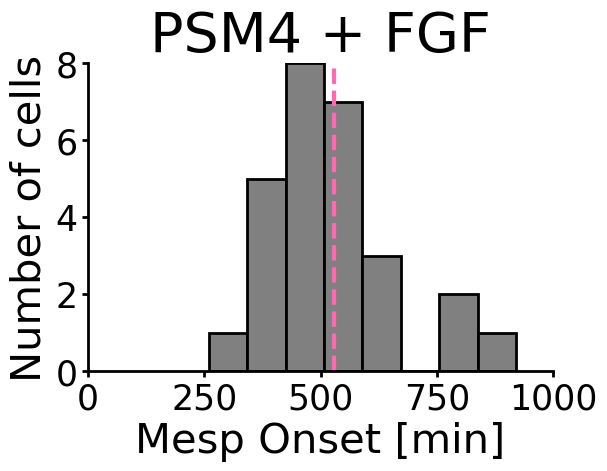

In [47]:
fig = plt.figure(figsize=[6,4])

onset_mesp = np.array(onset_mesp_fgf)

plt.hist(onset_mesp, bins='fd', linewidth=2, edgecolor='black', color='grey', alpha=1, density=False);
plt.axvline(np.mean(onset_mesp), linewidth=3, linestyle='dashed', color='hotpink')

plt.title('PSM4 + FGF', fontsize=40)
plt.xlabel('Mesp Onset [min]',fontsize=30)
plt.ylabel('Number of cells',fontsize=30)
plt.xticks(np.arange(0,1250,250), fontsize=25)
plt.yticks(np.arange(0,10,2), fontsize=25)
plt.xlim([0,1000])
plt.ylim([0,8])

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.show()
#fig.savefig('../Data/Figure 2/Figure 2 - In vitro/Results/MespOnset.pdf', format='pdf', bbox_inches='tight')

In [48]:
print(f'Mean +- SD = {np.mean(onset_mesp):.2f} +- {np.std(onset_mesp):.2f}')

Mean +- SD = 528.89 +- 136.82


## Last peak time vs Mesp Onset

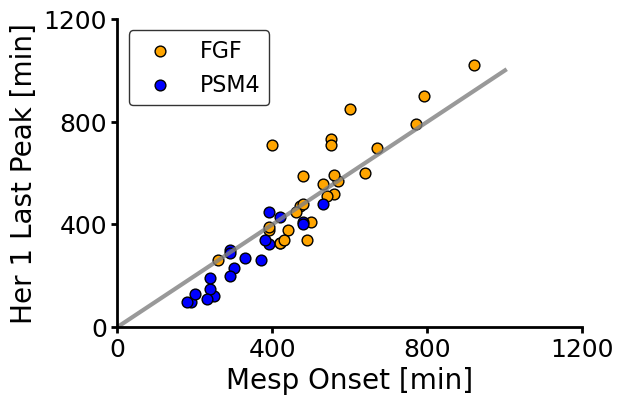

In [53]:
fig = plt.figure(figsize=[6,4])
plt.scatter(onset_mesp_fgf, onset_lp_fgf, color='orange', label='FGF', edgecolor='black', s=60, alpha=1)
plt.scatter(onset_mesp_psm4, onset_lp_psm4, color='blue', label=r'PSM4', edgecolor='black', s=60, alpha=1)
          
plt.xlabel('Mesp Onset [min]', fontsize=20)
plt.ylabel('Her 1 Last Peak [min]', fontsize=20)
plt.xticks(np.arange(0, 1400, 400), fontsize=18)
plt.yticks(np.arange(0, 1400, 400),fontsize=18)
plt.xlim([0,1200])
plt.ylim([0,1200])
plt.legend(loc='best', fontsize=16, edgecolor='black')

plt.plot([0, 1000], [0, 1000], '-', color='grey', linewidth=3,alpha=0.8)

ax = plt.gca() 
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.show()

#fig.savefig('../Data/Figure 3/Results/Correlations.pdf', bbox_inches='tight')

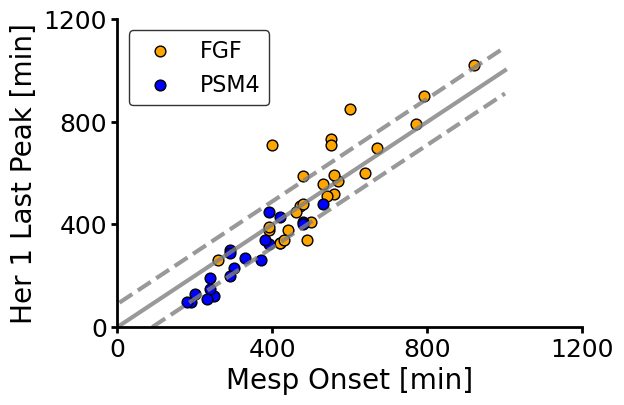

In [61]:
fig = plt.figure(figsize=[6,4])
plt.scatter(onset_mesp_fgf, onset_lp_fgf, color='orange', label='FGF', edgecolor='black', s=60, alpha=1)
plt.scatter(onset_mesp_psm4, onset_lp_psm4, color='blue', label=r'PSM4', edgecolor='black', s=60, alpha=1)
          
plt.xlabel('Mesp Onset [min]', fontsize=20)
plt.ylabel('Her 1 Last Peak [min]', fontsize=20)
plt.xticks(np.arange(0, 1400, 400), fontsize=18)
plt.yticks(np.arange(0, 1400, 400),fontsize=18)
plt.xlim([0,1200])
plt.ylim([0,1200])
plt.legend(loc='best', fontsize=16, edgecolor='black')

plt.plot([90, 1000], [0, 910], '--', color='grey', linewidth=3,alpha=0.8)
plt.plot([0, 1000], [0, 1000], '-', color='grey', linewidth=3,alpha=0.8)
plt.plot([-90, 1000], [0, 1090], '--', color='grey', linewidth=3,alpha=0.8)




ax = plt.gca() 
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)
plt.show()

#fig.savefig('../Data/Figure 3/Results/Correlations.pdf', bbox_inches='tight')